# Plot NOx emissions for different SSPs


In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from matplotlib import rcParams
import pandas as pd
import cftime
import glob
import os
import matplotlib.colors as colors

In [3]:
rcParams['font.size'] = 20
plotdir = '/div/nac/users/zofias/plots/ACACIA'

### Import data

In [4]:
#define file locations
file_loc1 = '/div/pdo/mariantl/ACACIA_AVIATE/Emissions/corrected_emis/' #infile path
filelist = sorted(glob.glob(f'{file_loc1}NOx*ssp*.nc'))

In [5]:
#check file list
filelist

['/div/pdo/mariantl/ACACIA_AVIATE/Emissions/corrected_emis/NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-AIM-ssp370-1-1_gn_201501-210012_correction.nc',
 '/div/pdo/mariantl/ACACIA_AVIATE/Emissions/corrected_emis/NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-IMAGE-ssp126-1-1_gn_201501-210012_correction.nc']

In [6]:
#select 2050
ds_nox_ems = xr.open_mfdataset(sorted(filelist),combine='nested',concat_dim='member').sel(time=slice('2050-01-01','2051-01-01'))
ds_nox_ems.coords['member'] = ['SSP370','SSP126'] 
# present day emissions
ds_nox_ems_pd = xr.open_dataset('/div/pdo/mariantl/ACACIA_AVIATE/Emissions/corrected_emis/NOx-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2021-04-21_gn_200001-201912_correction.nc').sel(time=slice('2015-01-01','2020-01-01'))

In [7]:
#area dataset
area_data = xr.open_dataset('/div/nac/users/zofias/CEDS_ems_ACACIA_gridarea.nc')

### Processing data
Convert units from kg m-2 s-1 to kg per year

In [8]:
per_sec_to_per_year = 3600*24*365

In [9]:
#convert to tg per year
ds_nox_ems['NOx_Tg_yr'] = ds_nox_ems['NOx_em_AIR_anthro']*area_data['cell_area']*per_sec_to_per_year/1e9
ds_nox_ems_pd['NOx_Tg_yr'] = ds_nox_ems_pd['NOx_em_AIR_anthro']*area_data['cell_area']*per_sec_to_per_year/1e9

ds_nox_ems_pd['NOx_Tg_yr'] = ds_nox_ems_pd['NOx_Tg_yr'].assign_attrs(
    units="Tg yr-1")

ds_nox_ems['NOx_Tg_yr'] = ds_nox_ems['NOx_Tg_yr'].assign_attrs(
    units="Tg yr-1")


In [10]:
#sum all emissions
ds_nox_ems['ann_sum'] = ds_nox_ems['NOx_Tg_yr'].sum(dim=["lon","lat","level"],keep_attrs=True)
ds_nox_ems_pd['ann_sum'] = ds_nox_ems_pd['NOx_Tg_yr'].sum(dim=["lon","lat","level"],keep_attrs=True)

Text(0.5, 1.0, 'NOx emissions')

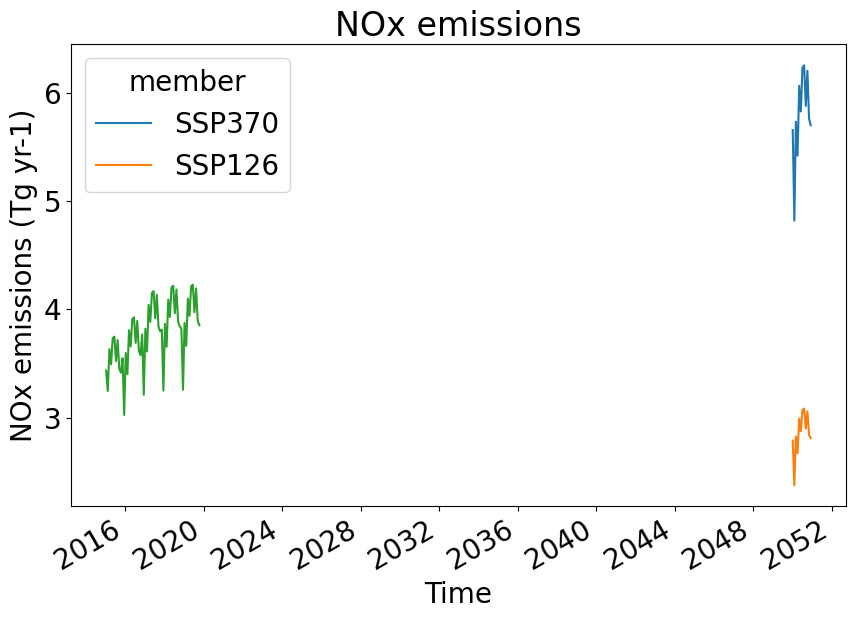

In [11]:
# Quick plot to check datasets
plt.figure(figsize=(10, 6))

ax = ds_nox_ems['ann_sum'].plot.line(x='time')
ds_nox_ems_pd['ann_sum'].plot.line(x='time',label='PD')


plt.xlabel(f'Time')
plt.ylabel('NOx emissions (Tg yr-1)')
plt.title('NOx emissions')
#plt.legend(fontsize=16)

Text(0.5, 1.0, 'Present day NOx emissions')

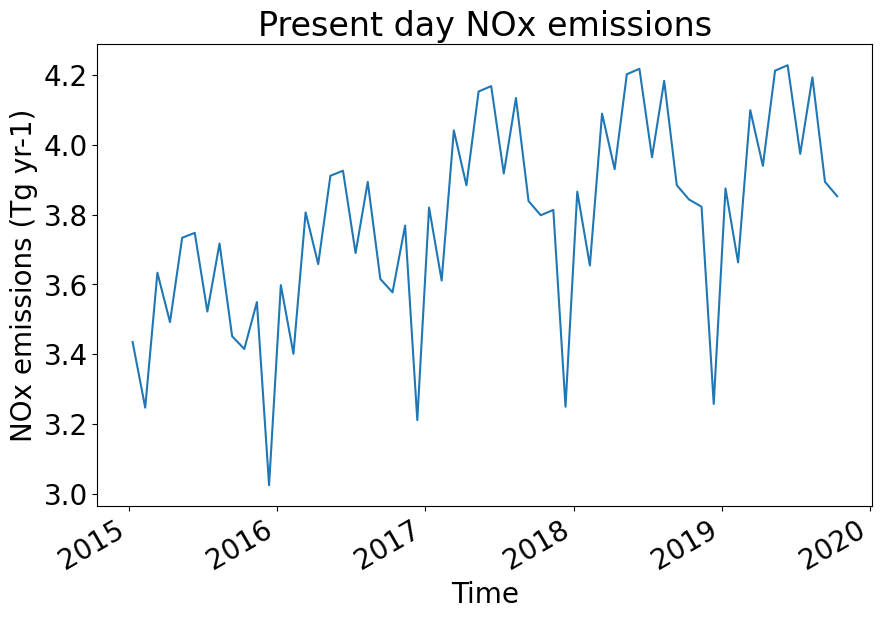

In [12]:
# Present day emissions 2015-2019
plt.figure(figsize=(10, 6))

#ax = ds_nox_ems['ann_sum'].plot.line(x='time')
ax = ds_nox_ems_pd['ann_sum'].plot.line(x='time')


plt.xlabel(f'Time')
plt.ylabel('NOx emissions (Tg yr-1)')
plt.title('Present day NOx emissions')
#plt.legend(fontsize=16)

Text(0.5, 1.0, 'NOx emissions in 2050')

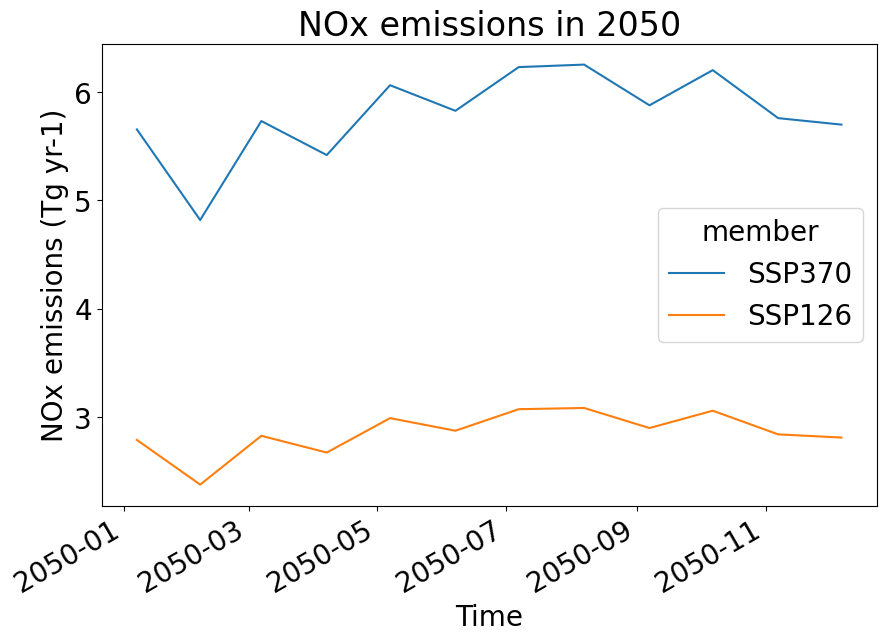

In [13]:
# 2050 emissions 
plt.figure(figsize=(10, 6))

ax = ds_nox_ems['ann_sum'].plot.line(x='time')

plt.xlabel(f'Time')
plt.ylabel('NOx emissions (Tg yr-1)')
plt.title('NOx emissions in 2050')
#plt.legend(fontsize=16)

### Calculate mean for relevant years

In [14]:
#annual mean NOx emissions
ds_nox_ems['nox_ems_glob_ann_mean'] = ds_nox_ems['ann_sum'].mean(dim='time')
ds_nox_ems_pd['nox_ems_glob_ann_mean'] = ds_nox_ems_pd['ann_sum'].mean(dim='time')

# zonal mean
ds_nox_ems['zon_mean'] = ds_nox_ems['NOx_Tg_yr'].sum(dim=["lon"],keep_attrs=True).mean(dim='time')
ds_nox_ems_pd['zon_mean'] = ds_nox_ems_pd['NOx_Tg_yr'].sum(dim=["lon"],keep_attrs=True).mean(dim='time')

ds_nox_ems['ds_nox_ems_diff_PD'] = ds_nox_ems['zon_mean'] - ds_nox_ems_pd['zon_mean']

### Plot differences between years

<Figure size 1000x600 with 0 Axes>

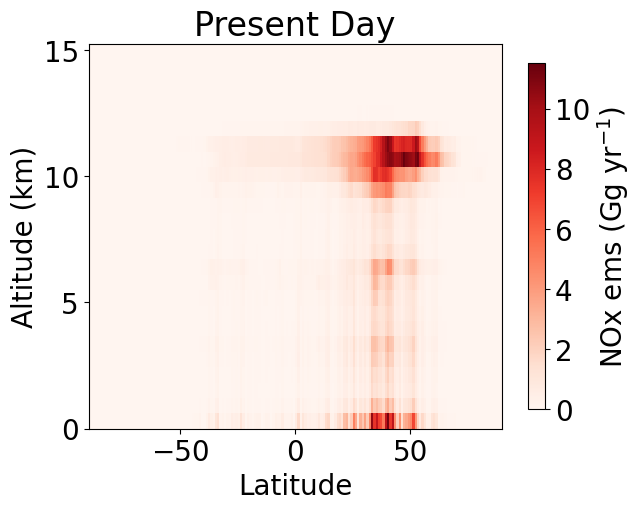

In [19]:
#absolute NOx emissions
plt.figure(figsize=(10, 6))

ax = (ds_nox_ems_pd['zon_mean']*1000).plot(size=5,cmap='Reds',cbar_kwargs={"orientation": "vertical", "shrink": 0.9, "aspect": 20,"pad":0.05,"label":f"NOx ems (Gg yr$^{{-1}}$)"})

plt.xlabel(f'Latitude')
plt.ylabel('Altitude (km)')
plt.title('Present Day')
plt.savefig(f'{plotdir}/ACACIA_NOxems_Fig1a_PD_zonal.pdf',format='pdf',bbox_inches='tight')

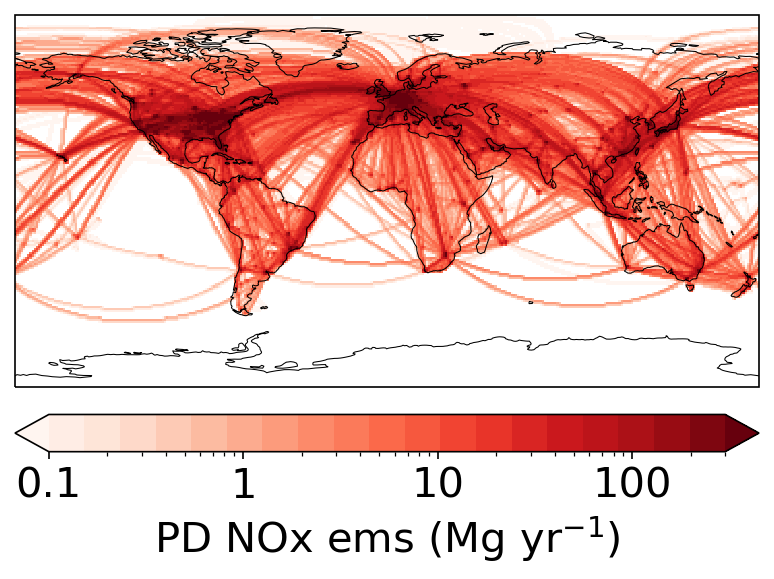

In [20]:
# map plot NOx PD ems
fig, axis = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fg = (ds_nox_ems_pd['NOx_Tg_yr']*1e6).sum(dim='level').mean(dim="time",keep_attrs=True).plot(transform=ccrs.PlateCarree(),
                                                                                        norm = colors.LogNorm(vmin=0.1, vmax=300),
                                                                                        cmap='Reds',
                                                                                        levels=20,
                                                                                        vmin=0.1,
                                                                                        vmax=300,
                                                                                        add_colorbar=False)
                                                                                        #cbar_kwargs={'label': f'PD NOx ems (Mg yr$^{{-1}}$)',"orientation": "horizontal"})
axis.coastlines(linewidth=0.5)

cbar = fig.colorbar(fg, label = f'PD NOx ems (Mg yr$^{{-1}}$)',orientation='horizontal',cmap='Reds',pad=0.05)
cbar.set_ticks([0.1,1,10,100],labels=[0.1,1,10,100])
plt.savefig(f'{plotdir}/ACACIA_NOxems_Fig1b_map.pdf',format='pdf',bbox_inches='tight')

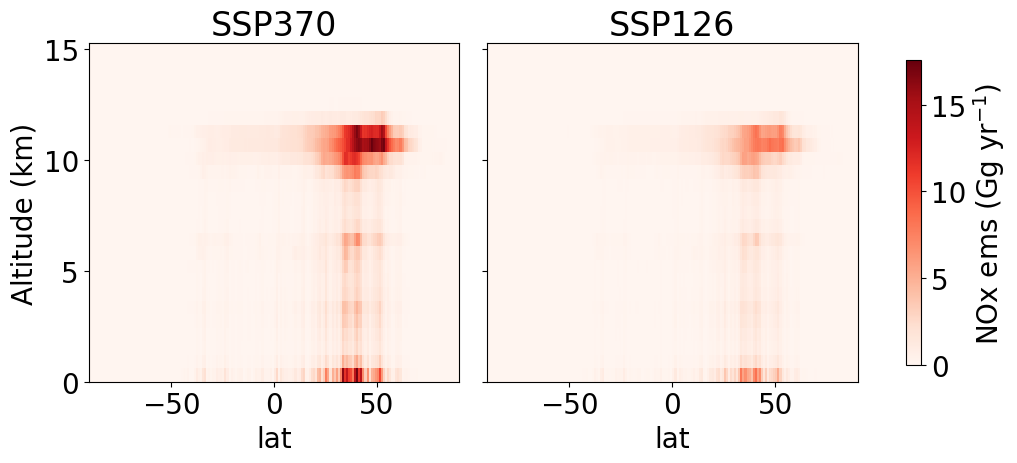

In [21]:
#absolute NOx emissions
fg = (ds_nox_ems['zon_mean']*1000).plot(size=5,
                                                                              cmap='Reds',
                                                                              col='member',
                                                                              col_wrap=2,
                                                                              cbar_kwargs={"orientation": "vertical", "shrink": 0.9, "aspect": 20,"pad":0.05,"label":f"NOx ems (Gg yr$^{{-1}}$)"},
                                                                              )

fg.set_ylabels('Altitude (km)')

for ax, title in zip(fg.axs.flat, ds_nox_ems.member.values):
    ax.set_title(f'{title}')
    

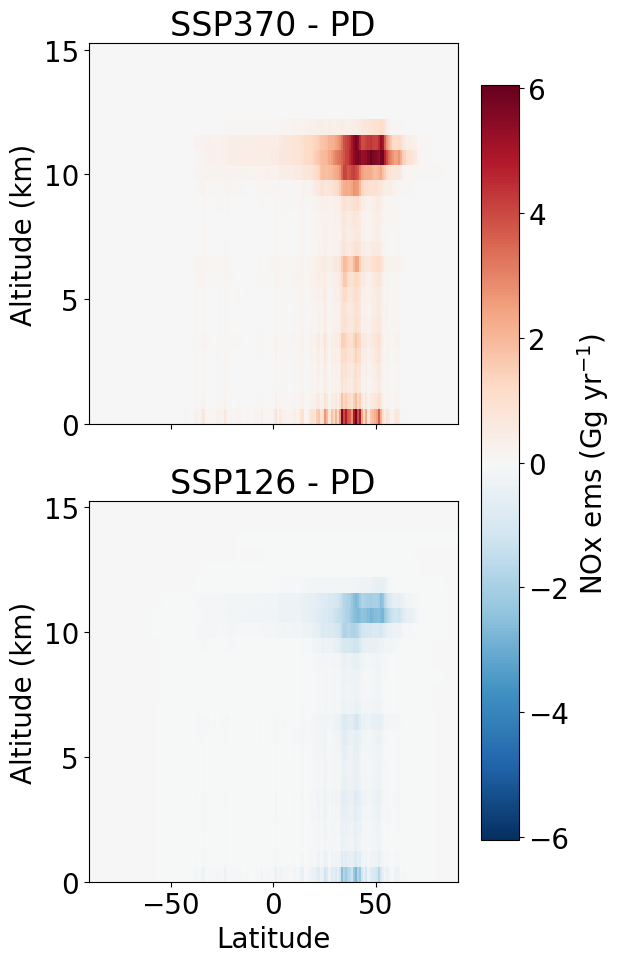

In [22]:
#NOx emissions difference to present day
fg = (ds_nox_ems['ds_nox_ems_diff_PD']*1000).plot(size=5,
                                                                              cmap='RdBu_r',
                                                                              col='member',
                                                                              col_wrap=1,
                                                                              cbar_kwargs={"orientation": "vertical", "shrink": 0.9, "aspect": 20,"pad":0.05,"label":f"NOx ems (Gg yr$^{{-1}}$)"},
                                                                              )

fg.set_ylabels('Altitude (km)')
fg.set_xlabels('Latitude')


for ax, title in zip(fg.axs.flat, ds_nox_ems.member.values):
    ax.set_title(f'{title} - PD')
plt.savefig(f'{plotdir}/ACACIA_NOxems_Fig1de_sspminuspd.pdf',format='pdf',bbox_inches='tight')

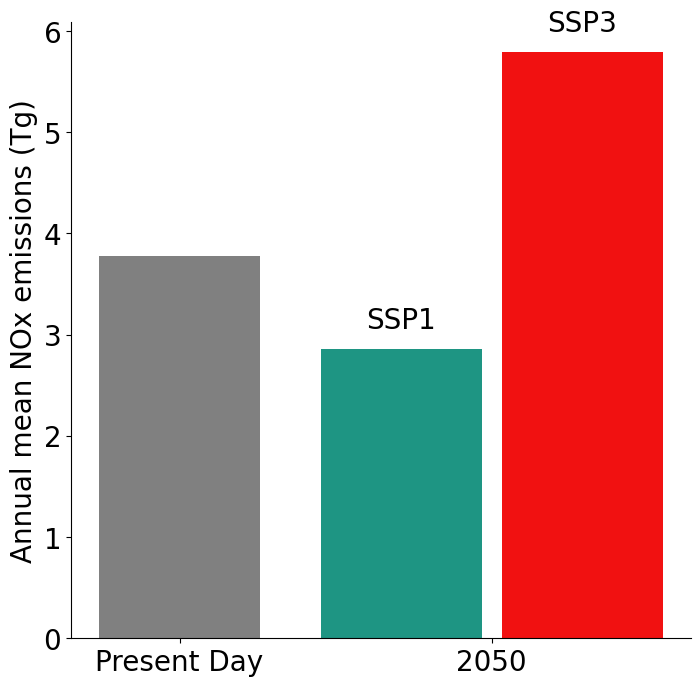

In [23]:
#absolute NOx emissions
fig, ax = plt.subplots(figsize=(8,8))

values1 = ds_nox_ems_pd['nox_ems_glob_ann_mean'].values
#ds_nox_ems_pd['nox_ems_glob_ann_mean'].plot(kind='bar',ax=ax)
ax.bar(x=1,height=ds_nox_ems_pd['nox_ems_glob_ann_mean'].values,width=0.4,label='PD',color='grey')
ax.bar(x=1.55,height=ds_nox_ems['nox_ems_glob_ann_mean'].values[1],width=0.4,label='SSP1',color='#1e9583')
plt.text(1.55,ds_nox_ems['nox_ems_glob_ann_mean'].values[1]+0.2,'SSP1',ha='center')
ax.bar(x=2,height=ds_nox_ems['nox_ems_glob_ann_mean'].values[0],width=0.4,label='SSP3', color='#f11111')
plt.text(2,ds_nox_ems['nox_ems_glob_ann_mean'].values[0]+0.2,'SSP3',ha='center')

ax.set_xticks([1,1.775])
ax.set_xticklabels(['Present Day','2050'], rotation=0)
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel(f'')
plt.ylabel('Annual mean NOx emissions (Tg)')
#plt.title('PD emissions')
#plt.legend()
plt.savefig(f'{plotdir}/ACACIA_NOxems_Fig1c_bar.pdf',format='pdf',bbox_inches='tight')

In [24]:
#print values for PD total
ds_nox_ems_pd['nox_ems_glob_ann_mean'].data

array(3.78102592)

In [25]:
#print values for 2050 SSP3 and SSP1 future totals
ds_nox_ems['nox_ems_glob_ann_mean'].values

array([5.79506271, 2.85762558])